# Poiseuille - BGK - Zou-He Constant Velocity Inlet and Outlet

In [11]:
# Python Imports
from pylab import *
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors
from IPython.display import display, Math, Latex

## Setting Simulation

### Lattice Paremeters

In [12]:
w0=4.0/9.0;w1=1.0/9.0;w2=1.0/36.0; # Lattice Weights
w = np.array([w0,w1,w1,w1,w1,w2,w2,w2,w2],dtype="float64") 
cx = np.array([0,1,0,-1, 0,1,-1,-1, 1],dtype="int8")  # Lattice Directions
cy = np.array([0,0,1, 0,-1,1, 1,-1,-1],dtype="int8")  # Lattice Directions
opp = np.array([0,3,4,1,2,7,8,5,6],dtype="uint8")  # Opposite Lattice Directions

### Problem Scaling: From Dimensionless to LBM Scale

In [13]:
#------------Dimensionless Parameter For Pro----------------
uo = 1.0 # Dimensionless Velocity
ho = 1.0 # Dimensionless Domain Length
Re = 10.0 # Reynolds Number
nuo = uo*ho/Re #Dimensionless Kinematic Viscosity

The problem scaling follow the equations:
$$
\Delta x=\frac{H_{0}}{Nx}, \quad \quad r=\frac{\Delta x}{\Delta t}, \quad \quad u=u_{0}\frac{\Delta t}{\Delta x}, \quad \quad \textrm{and} \quad \quad \nu=\nu_{0}\frac{\Delta t}{\Delta x^{2}}
$$
where $\Delta x $ is grid size, $\Delta y$ is time step and $r$ is the relation term. Dimensionless numbers
$$
Re=\frac{u_{0}\rho H}{\mu}=\frac{u_{0} H}{\nu} \quad \quad \textrm{and} \quad \quad C_{d}=\frac{24}{Re}\frac{L}{H}.
$$

In [14]:
import time
#---------------Numerical Domain Size--------------------
cases=3
Nx0 = np.array([10, 20, 40],dtype="int64")
Ny0 = np.array([12, 22, 42],dtype="int64")
r0 = np.array([2.0**(3), 2.0**(4), 2.0**(5)],dtype="float64")
mstep=10000
mstep0 = np.array([mstep*4**(0), mstep*4**(1), mstep*4**(2)],dtype="int64")
rhor = np.empty(len(Nx0), dtype=object)
Vxr = np.empty(len(Nx0), dtype=object)
Vyr = np.empty(len(Nx0), dtype=object)
Cdr = np.zeros((3),dtype="float64")
Mass = np.empty(len(Nx0), dtype=object)
for i in range(len(Nx0)):
    rhor[i] = np.zeros((int(Nx0[i]), int(Ny0[i])), dtype="float64")
    Vxr[i] = np.zeros((int(Nx0[i]), int(Ny0[i])), dtype="float64")
    Vyr[i] = np.zeros((int(Nx0[i]), int(Ny0[i])), dtype="float64")
    Mass[i] = np.zeros((int(mstep0[i])), dtype="float64")
for case in range(0,cases):
    Nx=Nx0[case]
    Ny=Ny0[case]
    #------------------------------------------Scaling Term--------------------------------------------
    dx = ho / (Ny-2) # Grid size 
    r = r0[case] # Relation term r=dx/dt
    dt = dx / r # Time Step
    #----------------------------------------LBM-Scale-----------------------------------------------
    nu = dt * nuo / (dx * dx)  #Scaling Viscosity
    ue = dt * uo / dx  #Scaling Velocity
    cs = 1.0 / sqrt(3.) #Sound Speed
    tau = (nu/ (cs * cs)) + (1.0/ 2.0) #Relaxation time
    rhoi = 1.0 #Initial Densty
    #--------------Print-Data-------------------------------------------------------------------------
    display(Math(r"\tau="+str(tau)+r"\quad\quad \nu="+str(nu)))
    display(Math(r"r="+str(r)+r"\quad\quad \overline{u}="+str(ue)))
    display(Math(r"dx="+str(dx)+r"\quad\quad dt="+str(dt)))
    #----------------Allocating array of solid nodes------------------------------------------------
    solid=np.ones((Nx,Ny),dtype="uint8") # Binary array to allocate the mapp of pore and solid # Parallel Plates
    solid[:,0] = 0
    solid[:,Ny-1] = 0
    #--------Allocating "imapp" array ti store the information of lattice directions that need be 
    # inverted during the Half-way Bounce-Back method.
    imapp=np.zeros((9,Nx,Ny),dtype="uint8") #Interface mapping for Half-Way Bounce-Back
    for i in range(0,Nx):
        for j in range (0, Ny):
            if (solid[i,j]==1):
                for k in range (0,9):
                    #-----------------------------------------
                    ii=i+cx[k] 
                    if (ii>Nx-1):ii=0
                    if (ii<0):ii=Nx-1
                    #-----------------------------------------
                    jj=j+cy[k] 
                    if (jj>Ny-1):jj=0
                    if (jj<0):jj=Ny-1
                    #-----------------------------------------
                    if (solid[ii,jj]==0):
                        imapp[k,i,j]=k
    #---------------------Field-Arrays---------------------------------------------------------------- 
    rho=np.zeros((Nx,Ny),dtype="float64") # Allocating Density field
    rho[:,:]=np.where(solid==1,rhoi,0.0) # Constant initial density field
    rhow=np.zeros((Ny),dtype="float64") # Allocating West Boundary Density
    rhoe=np.zeros((Ny),dtype="float64") # Allocating East Boundary Density
    up=np.zeros((Ny),dtype="float64") # Allocating Boundary Parabolic Profile
    y=np.linspace(0.5, Ny-2 -0.5, Ny-2)
    up[1:-1]=6.0 * ue * ( y/float(Ny - 2) - ( y/float(Ny - 2) )**2 );
    Vx=np.zeros((Nx,Ny),dtype="float64") # Allocating Null Velocity x Field
    Vy=np.zeros((Nx,Ny),dtype="float64") # Allocating Null Velocity y Field
    #----------------Initializing Distribution Functions----------------
    f=np.zeros((9,Nx,Ny),dtype="float64") # Allocating Pre-Collisional Distribution Function
    fp=np.zeros((9,Nx,Ny),dtype="float64") # Allocating Pos-Collisional Distribution Function
    feq=np.zeros((9,Nx,Ny),dtype="float64") # Allocating Pos-Collisional Distribution Function
    for k in range (0,9):
        f[k,:,:]=np.where(solid==1,w[k]*rho[:,:],0.0)
    #---------------------------------Main-Loop-------------------------------------------------------
    Cd=0.0; Cd0=0.0
    tolerance=0.000001
    start=time.time()
    #---------------------------------Main-Loop-------------------------------------------------------------------------------------
    for kk in range(0,mstep0[case]):
        #------------------------------------Collision-----------------------------------------------------------------------------
        for k in range(0,9):
            feq[k,:,:]=w[k]*rho*(1. + 3.*(Vx*cx[k]+Vy*cy[k]) + 4.5*(Vx*cx[k]+Vy*cy[k])**2-1.5*(Vx*Vx+Vy*Vy))
            fp[k,:,:]=np.where(solid==1, f[k,:,:]-(1.0/tau)*(f[k,:,:]-feq[k,:,:]), 0.0 )
        #----------------------------------Streaming---------------------------------------------------------------------------
        for k in range(0,9):
            f[k,:,:]=np.roll(np.roll(fp[k,:,:], cx[k], axis=0), cy[k], axis=1)
        #--------------------------------------Half-Way-------------------------------------------------------------------------
        for k in range(1,9):
            f[k,:,:]=np.where(imapp[opp[k],:,:]==opp[k],fp[opp[k],:,:],f[k,:,:])
        #--------------------------------------Zou-He-BC------------------------------------------------------------------------
        #--------------------Inlet------------------------------------------------------------
        rhow= (f[0,0,:] + f[2,0,:] + f[4,0,:] + 2 * (f[3,0,:] + f[6,0,:] +f[7,0,:]) )/(1.0-up)
        f[1,0,:] = f[3,0,:] + 2.0*rhow*up/3.0
        f[5,0,:] = f[7,0,:] - (f[2,0,:]-f[4,0,:])/2.0 + rhow*up/6.0
        f[8,0,:] = f[6,0,:] + (f[2,0,:]-f[4,0,:])/2.0 + rhow*up/6.0
        #--------------------Outlet (2ndOrd)------------------------------------------------------------
        k_list = [3, 6, 7]
        f[k_list, Nx-1, :] = f[k_list, Nx-2, :]

        #--------------------------------------Macro-Properties------------------------------------------------------------------
        rho=np.where(solid==1,np.einsum('ixy->xy', f),0.0) 
        Vx=np.divide(np.einsum('i,ixy->xy', cx, f), rho, out=np.zeros_like(Vx, dtype="float64"), where=rho!=0)
        Vy=np.divide(np.einsum('i,ixy->xy', cy, f), rho, out=np.zeros_like(Vy, dtype="float64"), where=rho!=0)
        #-------------------------------------Convergence------------------------------------------------------------------------
        rho_med = np.sum(rho)/(Nx*(Ny-2))
        Mass[case][kk] = rho_med
        if (kk%1000==0):
            Umed = np.sum(Vx)/(Nx*(Ny-2))
            rho_med = np.sum(rho)/(Nx*(Ny-2))
            dp = (sum(rho[0,:]) - sum(rho[Nx-1,:]))*cs**2/(Ny-2)
            Cd=dp/(rho_med*Umed**2/2.0)
            print('Da=',Cd,'\t Diff=',np.fabs(Cd-Cd0),'\t Umed=',Umed,'\t Erro=',np.fabs(Cd-24.0/Re))
            # if(np.fabs(Cd-Cd0)<tolerance):
            #     break
            Cd0=Cd
    Cdr[case]=Cd
    rhor[case]=rho
    Vxr[case]=Vx
    Vyr[case]=Vy

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Da= 616.0614643928451 	 Diff= 616.0614643928451 	 Umed= 0.012562499999999999 	 Erro= 613.6614643928451
Da= 1.9179316207071686 	 Diff= 614.143532772138 	 Umed= 0.11992784240776093 	 Erro= 0.4820683792928313
Da= 1.9179316207071668 	 Diff= 1.7763568394002505e-15 	 Umed= 0.11992784240776087 	 Erro= 0.4820683792928331
Da= 1.9179316207071933 	 Diff= 2.6423307986078726e-14 	 Umed= 0.11992784240776086 	 Erro= 0.48206837929280666
Da= 1.917931620707178 	 Diff= 1.532107773982716e-14 	 Umed= 0.11992784240776086 	 Erro= 0.482068379292822
Da= 1.917931620707163 	 Diff= 1.4876988529977098e-14 	 Umed= 0.11992784240776096 	 Erro= 0.48206837929283686
Da= 1.917931620707192 	 Diff= 2.886579864025407e-14 	 Umed= 0.11992784240776087 	 Erro= 0.482068379292808
Da= 1.917931620707191 	 Diff= 8.881784197001252e-16 	 Umed= 0.11992784240776083 	 Erro= 0.4820683792928089
Da= 1.9179316207071733 	 Diff= 1.7763568394002505e-14 	 Umed= 0.11992784240776094 	 Erro= 0.48206837929282664
Da= 1.917931620707182 	 Diff= 8.65973

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Da= 4592.988091112738 	 Diff= 4592.988091112738 	 Umed= 0.0031289062499999997 	 Erro= 4590.588091112739
Da= 2.1444514066787135 	 Diff= 4590.84363970606 	 Umed= 0.06080195630475254 	 Erro= 0.25554859332128643
Da= 2.14445140939439 	 Diff= 2.715676572506709e-09 	 Umed= 0.06080195630749412 	 Erro= 0.25554859060560986
Da= 2.1444514093943265 	 Diff= 6.350475700855895e-14 	 Umed= 0.06080195630749431 	 Erro= 0.25554859060567336
Da= 2.144451409394291 	 Diff= 3.552713678800501e-14 	 Umed= 0.06080195630749413 	 Erro= 0.2555485906057089
Da= 2.1444514093943026 	 Diff= 1.1546319456101628e-14 	 Umed= 0.06080195630749406 	 Erro= 0.25554859060569735
Da= 2.1444514093942586 	 Diff= 4.39648317751562e-14 	 Umed= 0.06080195630749408 	 Erro= 0.2555485906057413
Da= 2.144451409394305 	 Diff= 4.618527782440651e-14 	 Umed= 0.06080195630749423 	 Erro= 0.2555485906056951
Da= 2.1444514093943017 	 Diff= 3.1086244689504383e-15 	 Umed= 0.060801956307494257 	 Erro= 0.25554859060569823
Da= 2.144451409394315 	 Diff= 1.33

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Da= 35426.73692315072 	 Diff= 35426.73692315072 	 Umed= 0.0007814941406249998 	 Erro= 35424.33692315072
Da= 2.2666634624316697 	 Diff= 35424.470259688285 	 Umed= 0.030754930958910017 	 Erro= 0.1333365375683302
Da= 2.2671319159166887 	 Diff= 0.00046845348501900475 	 Umed= 0.030755657395794972 	 Erro= 0.1328680840833112
Da= 2.2671268445017163 	 Diff= 5.071414972412924e-06 	 Umed= 0.03075566203120987 	 Erro= 0.1328731554982836
Da= 2.2671267899868113 	 Diff= 5.451490503460832e-08 	 Umed= 0.030755661960901643 	 Erro= 0.13287321001318864
Da= 2.267126790272065 	 Diff= 2.852535985198301e-10 	 Umed= 0.030755661960064497 	 Erro= 0.13287320972793504
Da= 2.267126790279144 	 Diff= 7.079226094219848e-12 	 Umed= 0.03075566196006863 	 Erro= 0.1328732097208558
Da= 2.2671267902790686 	 Diff= 7.549516567451064e-14 	 Umed= 0.03075566196006871 	 Erro= 0.1328732097209313
Da= 2.2671267902792565 	 Diff= 1.8784973576657649e-13 	 Umed= 0.030755661960068736 	 Erro= 0.13287320972074346
Da= 2.2671267902791152 	 Di

Da= 2.267126790279195 	 Diff= 7.72715225139109e-14 	 Umed= 0.030755661960068844 	 Erro= 0.13287320972080474
Da= 2.267126790278985 	 Diff= 2.1005419625907962e-13 	 Umed= 0.030755661960068757 	 Erro= 0.1328732097210148
Da= 2.267126790279197 	 Diff= 2.1183055309847987e-13 	 Umed= 0.03075566196006866 	 Erro= 0.13287320972080296
Da= 2.2671267902795003 	 Diff= 3.0331293032759277e-13 	 Umed= 0.03075566196006869 	 Erro= 0.13287320972049965
Da= 2.267126790279158 	 Diff= 3.423927807943983e-13 	 Umed= 0.03075566196006869 	 Erro= 0.13287320972084204
Da= 2.267126790279145 	 Diff= 1.2878587085651816e-14 	 Umed= 0.030755661960068615 	 Erro= 0.13287320972085492
Da= 2.2671267902790895 	 Diff= 5.551115123125783e-14 	 Umed= 0.03075566196006861 	 Erro= 0.13287320972091043
Da= 2.2671267902790952 	 Diff= 5.773159728050814e-15 	 Umed= 0.03075566196006866 	 Erro= 0.13287320972090466
Da= 2.267126790279037 	 Diff= 5.81756864903582e-14 	 Umed= 0.030755661960068643 	 Erro= 0.13287320972096284
Da= 2.26712679027925

Da= 2.2671267902787555 	 Diff= 5.24469356832924e-13 	 Umed= 0.030755661960068757 	 Erro= 0.1328732097212444
Da= 2.267126790279089 	 Diff= 3.33510996597397e-13 	 Umed= 0.030755661960068688 	 Erro= 0.13287320972091088
Da= 2.267126790279118 	 Diff= 2.886579864025407e-14 	 Umed= 0.030755661960068716 	 Erro= 0.132873209720882
Da= 2.2671267902794248 	 Diff= 3.0686564400639327e-13 	 Umed= 0.030755661960068785 	 Erro= 0.13287320972057515
Da= 2.267126790279061 	 Diff= 3.637090628672013e-13 	 Umed= 0.030755661960068716 	 Erro= 0.13287320972093886
Da= 2.267126790278939 	 Diff= 1.2212453270876722e-13 	 Umed= 0.030755661960068667 	 Erro= 0.13287320972106098
Da= 2.267126790278952 	 Diff= 1.2878587085651816e-14 	 Umed= 0.030755661960068757 	 Erro= 0.1328732097210481
Da= 2.2671267902792893 	 Diff= 3.375077994860476e-13 	 Umed= 0.030755661960068636 	 Erro= 0.1328732097207106
Da= 2.2671267902792813 	 Diff= 7.993605777301127e-15 	 Umed= 0.030755661960068705 	 Erro= 0.1328732097207186
Da= 2.26712679027908

Text(0, 0.5, '$Y$')

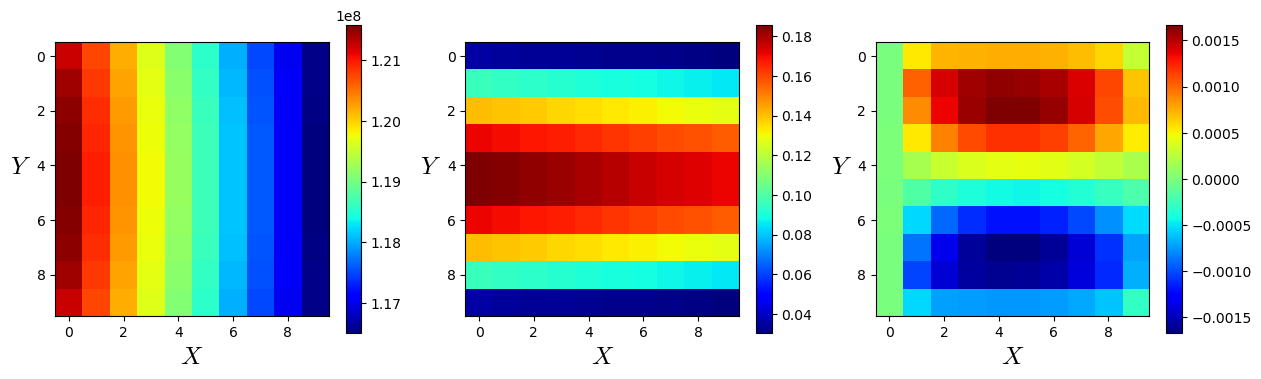

In [15]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
fig1, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(15,4))
img1=ax1.imshow(np.rot90(rhor[0][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img1, ax=ax1)
ax1.set_xlabel('$X$',fontsize=18)
ax1.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0)
img2=ax2.imshow(np.rot90(Vxr[0][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img2, ax=ax2)
ax2.set_xlabel('$X$',fontsize=18)
ax2.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0) 
img3=ax3.imshow(np.rot90(Vyr[0][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img3, ax=ax3)
ax3.set_xlabel('$X$',fontsize=18)
ax3.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0) 

In [16]:
Nx0 = np.array([10, 20, 40],dtype="int64")
Ny0 = np.array([12, 22, 42],dtype="int64")
r0 = np.array([2.0**(3), 2.0**(4), 2.0**(5)],dtype="float64")
Vxana = np.empty(len(Nx0), dtype=object)
for i in range(len(Nx0)):
    Vxana[i] = np.zeros((int(Nx0[i]), int(Ny0[i])), dtype="float64")
for i in range(len(Nx0)):
    y=np.linspace(0.5, Ny0[i]-2 -0.5, Ny0[i]-2) / float(Ny0[i] - 2)
    for ix in range(Nx0[i]):
        Vxana[i][ix,1:-1]=6.0 * (1.0/r0[i]) * ( y - ( y )**2 );

Text(0, 0.5, '$Y$')

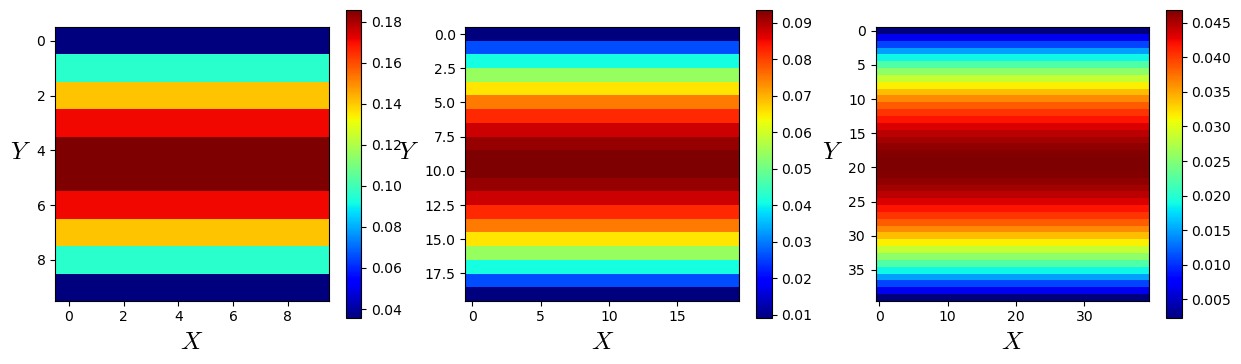

In [17]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
fig1, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(15,4))
img1=ax1.imshow(np.rot90(Vxana[0][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img1, ax=ax1)
ax1.set_xlabel('$X$',fontsize=18)
ax1.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0)
img2=ax2.imshow(np.rot90(Vxana[1][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img2, ax=ax2)
ax2.set_xlabel('$X$',fontsize=18)
ax2.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0) 
img3=ax3.imshow(np.rot90(Vxana[2][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img3, ax=ax3)
ax3.set_xlabel('$X$',fontsize=18)
ax3.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0) 

In [18]:
E0=sqrt(sum((Vxr[0][:,:]-Vxana[0][:,:])**2))/sqrt(sum((Vxana[0][:,:])**2))
E1=sqrt(sum((Vxr[1][:,:]-Vxana[1][:,:])**2))/sqrt(sum((Vxana[1][:,:])**2))
E2=sqrt(sum((Vxr[2][:,:]-Vxana[2][:,:])**2))/sqrt(sum((Vxana[2][:,:])**2))

<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_46860/2903882536.py:10: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta x$',fontsize=16)


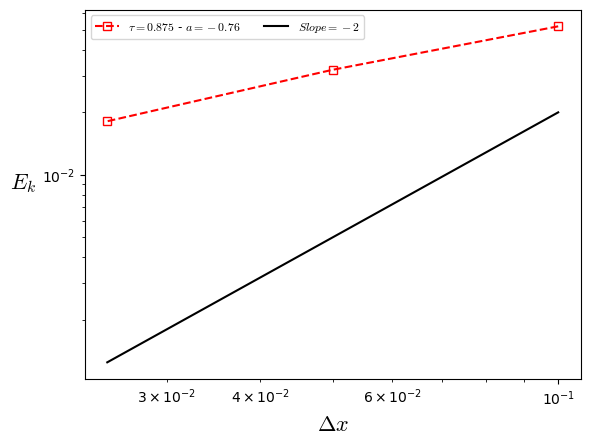

In [19]:
Malha=np.array([10,20,40])
Ek = np.array([E0,E1,E2])
TEk=np.polyfit(np.log(Malha), np.log(Ek), 1)
# Ek1 = np.array([0.000885053175400552,0.0002657329674660147,7.199195200913167e-05,1.8693115438450647e-05])
# TEk1=np.polyfit(np.log(Malha), np.log(Ek1), 1)
plt.loglog(1/Malha,Ek,'rs--',fillstyle='none')
# plt.loglog(1/Malha,Ek1,'bs--',fillstyle='none')
plt.loglog(1/Malha,2.0*1.0/(Malha**2),'k-',fillstyle='none')
plt.ylabel('$E_{k}$',fontsize=16,rotation=0,horizontalalignment='right')
plt.xlabel('$\Delta x$',fontsize=16)
plt.legend([fr'$\tau=0.875$ - $a={TEk[0]:.2f}$','$Slope=-2$'],loc=2,ncol=3,fontsize=8.5)

<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:6: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_46860/3887496154.py:6: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$\overline{M}$',fontsize=16,rotation=0,horizontalalignment='right')


Text(0.5, 0, '$t$')

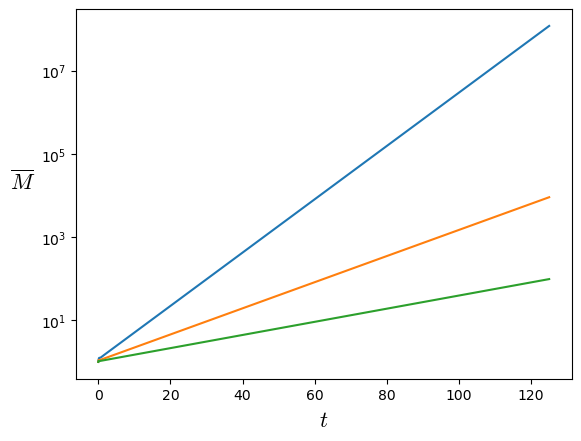

In [20]:
Nx0 = np.array([10, 20, 40],dtype="int64")
r0 = np.array([2.0**(3), 2.0**(4), 2.0**(5)],dtype="float64")
plt.semilogy(np.linspace(0,len(Mass[0]),len(Mass[0]))/Nx0[0]/r0[0],Mass[0])
plt.plot(np.linspace(0,len(Mass[1]),len(Mass[1]))/Nx0[1]/r0[1],Mass[1])
plt.plot(np.linspace(0,len(Mass[2]),len(Mass[2]))/Nx0[2]/r0[2],Mass[2])
plt.ylabel('$\overline{M}$',fontsize=16,rotation=0,horizontalalignment='right')
plt.xlabel('$t$',fontsize=16)